<a href="https://colab.research.google.com/github/tocom242242/notebooks/blob/master/anomaly_detection/deepSVDD_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

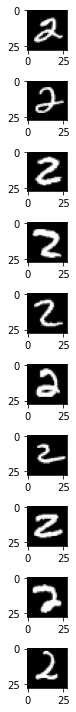

In [ ]:
import os
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from glob import glob
from tqdm import tqdm

def get_loaders(normal_label, abnormal_label, batch_size):
    # ds = torchvision.datasets.FashionMNIST
    ds = torchvision.datasets.MNIST
    transform = transforms.Compose([ 
                                    transforms.ToTensor(),
                                    ])
    transform_test = transforms.Compose([ 

                                    transforms.ToTensor(),
                                    ])
    coarse = {}
    trainset = ds(root='data', train=True, download=True, transform=transform, **coarse)
    testset = ds(root='data', train=False, download=True, transform=transform_test, **coarse)


    train_idx = (trainset.targets==normal_label)
    trainset.targets = trainset.targets[train_idx]
    trainset.data = trainset.data[train_idx]

    test_idx = (testset.targets==normal_label) | (testset.targets==abnormal_label)
    testset.targets = testset.targets[test_idx]
    testset.data = testset.data[test_idx]

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                drop_last=False)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                                drop_last=False)
    return train_loader, test_loader


def plot_ds(dataset, row=10, col=2, figsize=(20,10)):
    fig_img, ax_img = plt.subplots(row, 1, figsize=figsize, tight_layout=True)
    plt.figure()
    for i in range(row):
        sample,_ = dataset[i]
        img1 = sample
        img1 = denormalization(img1.cpu().detach().numpy())
        img1 = np.squeeze(img1)
        ax_img[i].imshow(img1, cmap="gray")
        
    fig_img.savefig("data_sample.png", dpi=100)
    plt.close()


def denormalization(x):
    x = (x.transpose(1, 2, 0) * 255.0).astype(np.uint8)
    return x

normal_label = 2
abnormal_label = 3
train_loader, test_loader = get_loaders(normal_label, abnormal_label, batch_size=32)
imgs, _ = next(iter(train_loader))
plot_ds(train_loader.dataset)



In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_center(model, device, train_loader):
    model.to(device)
    train_feature_space = []
    with torch.no_grad():
        for (imgs, _) in tqdm(train_loader, desc='Train set feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            # print(features.shape)
            train_feature_space.append(features)
        train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
    return train_feature_space
    

In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device", device)
import torchvision.models as models

class DeepSVDDModel(pl.LightningModule):
    def __init__(self):
        super(DeepSVDDModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=8,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.Flatten()
            )
        
        self.proj = nn.Sequential(
            nn.Linear(128, 100),
            nn.ReLU(True),
            nn.Linear(100, 50),
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.proj(z)
        return z

    def set_center(self, center):
        self.center = center

    def training_step(self, batch, batch_idx):
        x, _ = batch
        z = self.encoder(x)
        loss = (z-self.center).sum()**2
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        z = self.encoder(x)
        loss = (z-self.center).sum()**2
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_train_start(self):
        print("Starting training")

    def on_test_start(self):
        print("Starting testing")

    def on_train_end(self):
        print("Training is ending")

    def on_test_end(self):
        print("Testing is ending")


def fit(model, train_loader, test_loader, center):
    output_dir = "./"
    checkpoint_callback = ModelCheckpoint(
        dirpath=output_dir,
        filename="best_weights",
        monitor="val_loss",
        save_last=True,
        save_top_k=1,
        save_weights_only=True,
        mode="min",
    )

    trainer = pl.Trainer(devices=1, accelerator="gpu",max_epochs=30,callbacks=[checkpoint_callback])
    model = model.to(device)
    trainer.fit(model, train_loader, test_loader)
    model.load_state_dict(
            torch.load(os.path.join("./", "best_weights.ckpt"))["state_dict"],
            strict=False,
        )
    return model.encoder

model = DeepSVDDModel()
feature_space = get_center(model.encoder, device, train_loader)
center = torch.FloatTensor(feature_space).mean(dim=0)
center = center.to(device)
model.set_center(center)


Train set feature extracting: 100%|██████████| 187/187 [00:00<00:00, 241.84it/s]


In [ ]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device

device(type='cuda')

Test set feature extracting: 100%|██████████| 64/64 [00:00<00:00, 151.94it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0.587702433034001


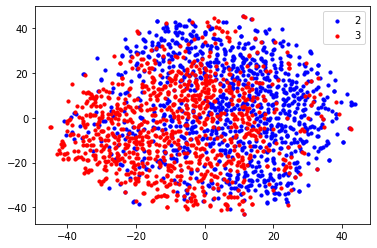

In [ ]:
from tqdm import tqdm
import faiss
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot  as plt

def knn_score(train_set, test_set, n_neighbours=1):
    index = faiss.IndexFlatL2(train_set.shape[1])
    index.add(train_set)
    D, _ = index.search(test_set, n_neighbours)
    return np.sum(D, axis=1)

def plot_scatter(x_test,y_test):
    scatter_x = x_test[:, 0]
    scatter_y = x_test[:, 1]
    
    cdict = {normal_label: 'blue', abnormal_label: 'red'}
    fig, ax = plt.subplots()
    for g in np.unique(y_test):
        ix = np.where(y_test == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 10)

    plt.legend()


transform = transforms.Compose([ transforms.ToTensor(),transforms.Lambda(lambda x: x.repeat(3, 1, 1)), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

def eval_plot_features(model, device, train_loader, test_loader,epoch):
    model.to(device)
    train_feature_space = []
    with torch.no_grad():
        for (imgs, _) in tqdm(train_loader, desc='Train set feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            train_feature_space.append(features)
        train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
    test_feature_space = []
    test_labels = []
    with torch.no_grad():
        for (imgs, labels) in tqdm(test_loader, desc='Test set feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            test_feature_space.append(features)
            test_labels.append(labels)
        test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
        test_labels = torch.cat(test_labels, dim=0).cpu().numpy()



    X_reduced_test = TSNE(n_components=2, random_state=0).fit_transform(test_feature_space)
    plot_scatter(X_reduced_test,test_labels)

    distances = knn_score(train_feature_space, test_feature_space)
    auc = roc_auc_score(test_labels, distances)

    # return train_feature_space, test_feature_space, test_labels,
    return auc,train_feature_space


auc, feature_space = eval_plot_features(model, device, train_loader, test_loader, 0)
print("AUC",auc)

In [ ]:
model = fit(model, train_loader, train_loader,center)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 6.2 K 
1 | proj    | Sequential | 17.9 K
---------------------------------------
24.2 K    Trainable params
0         Non-trainable params
24.2 K    Total params
0.097     Total estimated model params size (

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpu

Training: 0it [00:00, ?it/s]

Starting training


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Training is ending


Test set feature extracting: 100%|██████████| 64/64 [00:00<00:00, 158.19it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0.9123157955330417


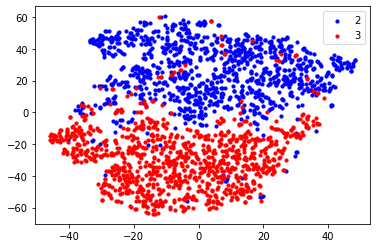

In [ ]:
auc, feature_space = eval_plot_features(model, device, train_loader, test_loader, 0)
print(auc)